# Auto Encoder: 이미지 노이즈 제거

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
import warnings
from google.colab import drive

drive.mount("/content/drive")
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "/content/drive/MyDrive/MNIST"
model_path = "/content/drive/MyDrive/model.pth"
learning_rate = 0.001
n_epochs = 10
batch_size = 128
noise_factor = 0.5

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def add_noise(inputs):
    noise = torch.randn_like(inputs) * noise_factor
    return inputs + noise


def preprocess(inputs):
    inputs = inputs.view(inputs.size(0), -1)
    noisy_inputs = add_noise(inputs)
    noisy_inputs = torch.clamp(noisy_inputs, -1.0, 1.0)
    return inputs, noisy_inputs

## 모델 정의 및 학습

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
criterion.to(device)

In [7]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        real_images, noisy_images = preprocess(images)
        real_images = real_images.to(device)
        noisy_images = noisy_images.to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, real_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}], Loss: {avg_loss:.4f}")

Epoch [1], Loss: 0.1826
Epoch [2], Loss: 0.0884
Epoch [3], Loss: 0.0721
Epoch [4], Loss: 0.0637
Epoch [5], Loss: 0.0578
Epoch [6], Loss: 0.0535
Epoch [7], Loss: 0.0506
Epoch [8], Loss: 0.0486
Epoch [9], Loss: 0.0466
Epoch [10], Loss: 0.0448


## 노이즈 제거 결과

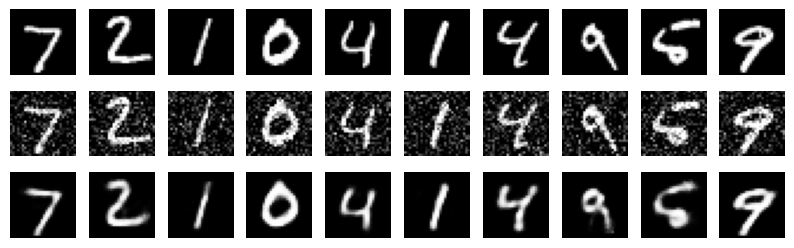

In [8]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        real_images, noisy_images = preprocess(images)
        real_images = real_images.to(device)
        noisy_images = noisy_images.to(device)

        outputs = model(noisy_images)
        break

# Visualize
real_images = real_images.cpu().view(-1, 28, 28)
noisy_images = noisy_images.cpu().view(-1, 28, 28)
outputs = outputs.cpu().view(-1, 28, 28)

fig, axes = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(real_images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(noisy_images[i], cmap="gray")
    axes[1, i].axis("off")
    axes[2, i].imshow(outputs[i].detach().numpy(), cmap="gray")
    axes[2, i].axis("off")
plt.show()

In [9]:
torch.save(model.state_dict(), model_path)